## 1. Imports and Load Data

In [1]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    XLMRobertaForSequenceClassification,
    TrainerCallback
    )
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from datasets import Dataset, DatasetDict
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score






c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_df = pd.read_csv("../data/cleaned/finetuning-splitstrain_set.csv")
test_df = pd.read_csv("../data/cleaned/finetuning-splitstest_set.csv")

print("=== ORIGINALE Distribution ===")
print("Train set (433):")
print(train_df['label'].value_counts())
print("\nTest set (109):")
print(test_df['label'].value_counts())


train_df = train_df.rename(columns={"label": "labels"})
test_df = test_df.rename(columns={"label": "labels"})



=== ORIGINALE Distribution ===
Train set (433):
label
2    300
0     94
1     39
Name: count, dtype: int64

Test set (109):
label
2    75
0    24
1    10
Name: count, dtype: int64


### CALCULATE THE WEIGHTS OF THE CLASSES

In [114]:
print("\n" + "="*60)
print("COMPUTING CLASS WEIGHTS")
print("="*60)

# Compute from actual training data (not from hardcoded counts)
train_labels = train_df['labels'].values
classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# Display class distribution and weights
class_counts = train_df['labels'].value_counts().sort_index()
for i, (cls, count) in enumerate(class_counts.items()):
    print(f"Class {cls}: {count} samples → Weight: {class_weights[i]:.4f}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"\nWeight tensor: {class_weights_tensor}")


COMPUTING CLASS WEIGHTS
Class 0: 94 samples → Weight: 1.5355
Class 1: 39 samples → Weight: 3.7009
Class 2: 300 samples → Weight: 0.4811

Weight tensor: tensor([1.5355, 3.7009, 0.4811])


## Data augmentation

In [115]:
import nltk
import nlpaug.augmenter.word as naw

nltk.data.path = ["C:/nltk_data"]

nltk.download('averaged_perceptron_tagger', download_dir="C:/nltk_data")
nltk.download('wordnet', download_dir="C:/nltk_data")
nltk.download('punkt', download_dir="C:/nltk_data")
nltk.download('omw-1.4', download_dir="C:/nltk_data")  # nécessaire pour wordnet

aug = naw.SynonymAug(aug_src='wordnet', aug_max=2)

# Fonction pour augmenter la classe 1 et 0
def augment_texts(df, label, n_aug=3):
    texts_to_aug = df[df['labels']==label]['text'].tolist()
    augmented_texts = []
    augmented_labels = []

    for txt in texts_to_aug:
        for _ in range(n_aug):
            try:
                new_txt = aug.augment(txt)
            except LookupError:
                # En cas d'erreur, garder le texte original
                new_txt = txt
            augmented_texts.append(new_txt)
            augmented_labels.append(label)
    
    df_aug = pd.DataFrame({"text": augmented_texts, "labels": augmented_labels})
    return df_aug

# Exemple : augmenter classe 1 et 0
aug_class1 = augment_texts(train_df, label=1, n_aug=5)
aug_class0 = augment_texts(train_df, label=0, n_aug=2)

# Concaténer avec le dataset original
train_df_aug = pd.concat([train_df, aug_class1, aug_class0]).reset_index(drop=True)
print(train_df_aug['labels'].value_counts())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to

labels
2    300
0    282
1    234
Name: count, dtype: int64


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perce

In [116]:
print(train_df_aug['labels'].value_counts())
print(train_df_aug.head())


labels
2    300
0    282
1    234
Name: count, dtype: int64
                                                text  labels
0  Il possède toutes les fonctionnalités dont vou...       2
1                                   Très bon service       2
2  Ils ne répondent jamais au téléphone ! Je suis...       0
3  La meilleur destination pour ceux qui veux pra...       2
4  C'est vraiment trop bruyant en entend tout dan...       0


## 2.Load the XLM-RoBERTa-base tokenizer and tokenise the dataset

In [117]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    enc = tokenizer(
        batch["text"],  # ton texte
        truncation=True,
        padding="max_length",
        max_length=96
    )
    enc["labels"] = batch["labels"]
    return enc


hf_train = Dataset.from_pandas(train_df_aug)

hf_train = Dataset.from_pandas(train_df)
hf_test = Dataset.from_pandas(test_df)

hf_train = hf_train.map(tokenize_fn, batched=True)
hf_test = hf_test.map(tokenize_fn, batched=True)

hf_train = hf_train.remove_columns(["text"])
hf_test = hf_test.remove_columns(["text"])



hf_train = hf_train.with_format("torch")
hf_test = hf_test.with_format("torch")


Map: 100%|██████████| 109/109 [00:00<00:00, 9276.80 examples/s]


In [118]:
print(hf_train[0])


{'labels': tensor(2), 'input_ids': tensor([     0,    891, 136134,  12847,    199, 217462,      7,  13319,   1023,
         19116,  27574,      4,    253,     96,     25,   3355,  63928,    104,
            25,    309,  30823,      8,  16530,     13,      2,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
     

## 3.Prepare for training
### INITIALIZING WEIGHTED LOSS MODEL

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

weights = class_weights_tensor.to(device)

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss



Using device: cpu


### Define the training arguments

In [120]:
training_args = TrainingArguments(
    output_dir="./results_xlm_roberta",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,      # essential
    save_total_limit=2,
    metric_for_best_model="f1",       # important
    greater_is_better=True,
    logging_dir="./logs"

)


### metrics calculation

In [124]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'),
        "f1": f1_score(labels, preds, average='weighted'),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "recall_macro": recall_score(labels, preds, average="macro"),
        "recall_class1": recall_score(labels, preds, average=None)[1],  # classe 1
    }


### Charge the model and Create the Trainer with Early Stopping

In [125]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(classes)
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4.Train the model

In [127]:
trainer.train()


 14%|█▍        | 78/550 [06:37<40:05,  5.10s/it]

                                             

{'loss': 1.0317, 'grad_norm': 78.89682006835938, 'learning_rate': 2e-05, 'epoch': 1.0}


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


{'eval_loss': 1.0015774965286255, 'eval_accuracy': 0.6880733944954128, 'eval_precision': 0.7036080487240768, 'eval_recall': 0.6880733944954128, 'eval_f1': 0.6904312911719354, 'eval_f1_macro': 0.49352000264779167, 'eval_f1_weighted': 0.6904312911719354, 'eval_recall_macro': 0.5133333333333333, 'eval_recall_class1': 0.1, 'eval_runtime': 10.1971, 'eval_samples_per_second': 10.689, 'eval_steps_per_second': 1.373, 'epoch': 1.0}


{'loss': 0.8798, 'grad_norm': 676.7368774414062, 'learning_rate': 1.7777777777777777e-05, 'epoch': 2.0}


100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


{'eval_loss': 0.7186926007270813, 'eval_accuracy': 0.8256880733944955, 'eval_precision': 0.80851293703475, 'eval_recall': 0.8256880733944955, 'eval_f1': 0.812548960298133, 'eval_f1_macro': 0.630290856407326, 'eval_f1_weighted': 0.812548960298133, 'eval_recall_macro': 0.6088888888888889, 'eval_recall_class1': 0.2, 'eval_runtime': 10.3054, 'eval_samples_per_second': 10.577, 'eval_steps_per_second': 1.359, 'epoch': 2.0}


{'loss': 0.7226, 'grad_norm': 27.631547927856445, 'learning_rate': 1.555555555555556e-05, 'epoch': 3.0}


100%|██████████| 14/14 [00:09<00:00,  1.61it/s]


{'eval_loss': 0.7426889538764954, 'eval_accuracy': 0.8532110091743119, 'eval_precision': 0.8410977401803089, 'eval_recall': 0.8532110091743119, 'eval_f1': 0.8332801682140514, 'eval_f1_macro': 0.6798132138575124, 'eval_f1_weighted': 0.8332801682140514, 'eval_recall_macro': 0.6505555555555556, 'eval_recall_class1': 0.2, 'eval_runtime': 9.9923, 'eval_samples_per_second': 10.908, 'eval_steps_per_second': 1.401, 'epoch': 3.0}


{'loss': 0.6127, 'grad_norm': 35.312618255615234, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.0}


100%|██████████| 14/14 [00:17<00:00,  1.29s/it]


{'eval_loss': 0.7336704134941101, 'eval_accuracy': 0.8532110091743119, 'eval_precision': 0.8336823560696716, 'eval_recall': 0.8532110091743119, 'eval_f1': 0.841181137564305, 'eval_f1_macro': 0.6822809425760695, 'eval_f1_weighted': 0.841181137564305, 'eval_recall_macro': 0.6694444444444444, 'eval_recall_class1': 0.2, 'eval_runtime': 19.0018, 'eval_samples_per_second': 5.736, 'eval_steps_per_second': 0.737, 'epoch': 4.0}


{'loss': 0.5315, 'grad_norm': 1.4783875942230225, 'learning_rate': 1.1111111111111113e-05, 'epoch': 5.0}


100%|██████████| 14/14 [00:07<00:00,  2.04it/s]


{'eval_loss': 0.7985931038856506, 'eval_accuracy': 0.8348623853211009, 'eval_precision': 0.8454267445093133, 'eval_recall': 0.8348623853211009, 'eval_f1': 0.8395039344381187, 'eval_f1_macro': 0.7088449714536672, 'eval_f1_weighted': 0.8395039344381187, 'eval_recall_macro': 0.708888888888889, 'eval_recall_class1': 0.4, 'eval_runtime': 7.7491, 'eval_samples_per_second': 14.066, 'eval_steps_per_second': 1.807, 'epoch': 5.0}


{'loss': 0.4258, 'grad_norm': 8.240467071533203, 'learning_rate': 8.888888888888888e-06, 'epoch': 6.0}


100%|██████████| 14/14 [00:07<00:00,  2.02it/s]


{'eval_loss': 1.2210114002227783, 'eval_accuracy': 0.8440366972477065, 'eval_precision': 0.8120345385860765, 'eval_recall': 0.8440366972477065, 'eval_f1': 0.8211232574764685, 'eval_f1_macro': 0.6245129870129871, 'eval_f1_weighted': 0.8211232574764685, 'eval_recall_macro': 0.6077777777777778, 'eval_recall_class1': 0.1, 'eval_runtime': 7.7653, 'eval_samples_per_second': 14.037, 'eval_steps_per_second': 1.803, 'epoch': 6.0}


{'loss': 0.3477, 'grad_norm': 0.469804584980011, 'learning_rate': 6.666666666666667e-06, 'epoch': 7.0}


100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


{'eval_loss': 1.4082540273666382, 'eval_accuracy': 0.8440366972477065, 'eval_precision': 0.8119266055045872, 'eval_recall': 0.8440366972477065, 'eval_f1': 0.822199691716742, 'eval_f1_macro': 0.6309873215533592, 'eval_f1_weighted': 0.822199691716742, 'eval_recall_macro': 0.6172222222222222, 'eval_recall_class1': 0.1, 'eval_runtime': 7.6134, 'eval_samples_per_second': 14.317, 'eval_steps_per_second': 1.839, 'epoch': 7.0}



 70%|███████   | 385/550 [1:05:25<28:02, 10.20s/it]

{'train_runtime': 3925.9441, 'train_samples_per_second': 1.103, 'train_steps_per_second': 0.14, 'train_loss': 0.6502669000006341, 'epoch': 7.0}


TrainOutput(global_step=385, training_loss=0.6502669000006341, metrics={'train_runtime': 3925.9441, 'train_samples_per_second': 1.103, 'train_steps_per_second': 0.14, 'total_flos': 212003636334336.0, 'train_loss': 0.6502669000006341, 'epoch': 7.0})

In [128]:
metrics = trainer.evaluate(eval_dataset=hf_test)
print("Evaluation metrics on test set:")
print(metrics)


100%|██████████| 14/14 [00:07<00:00,  1.99it/s]

Evaluation metrics on test set:
{'eval_loss': 0.7336704134941101, 'eval_accuracy': 0.8532110091743119, 'eval_precision': 0.8336823560696716, 'eval_recall': 0.8532110091743119, 'eval_f1': 0.841181137564305, 'eval_f1_macro': 0.6822809425760695, 'eval_f1_weighted': 0.841181137564305, 'eval_recall_macro': 0.6694444444444444, 'eval_recall_class1': 0.2, 'eval_runtime': 7.6263, 'eval_samples_per_second': 14.293, 'eval_steps_per_second': 1.836, 'epoch': 7.0}


In [129]:
predictions = trainer.predict(hf_test)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


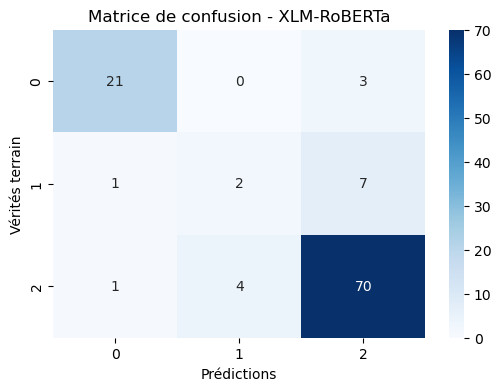

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# matrice brute
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - XLM-RoBERTa")
plt.show()


### Save metrics

In [ ]:
import json
from sklearn.metrics import classification_report


results_json = {
    "model_info": {
        "model_name": model_name,   
        "train_samples": len(train_df),
        "test_samples": len(test_df),
        "class_distribution": {
            "0_Négatif": (train_df['labels'] == 0).sum(),
            "1_Neutre": (train_df['labels'] == 1).sum(),
            "2_Positif": (train_df['labels'] == 2).sum(),
        },
    },
    "transformer_model": {
        "accuracy": metrics.get("eval_accuracy"),
        "precision": metrics.get("eval_precision"),
        "recall": metrics.get("eval_recall"),
        "f1_weighted": metrics.get("eval_f1_weighted"),
        "f1_macro": metrics.get("eval_f1_macro"),
    }
}

predictions = trainer.predict(hf_test)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

report = classification_report(
    y_true, 
    y_pred, 
    target_names=["negatif", "neutre", "positif"],
    output_dict=True
)

results_json["classification_report"] = report

def to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    return obj

with open("evaluation_finetuning_augmentation.json", "w", encoding="utf-8") as f:
    json.dump(results_json, f, indent=4, ensure_ascii=False, default=to_serializable)

print("file saved: evaluation_finetuning_augmentation.json")


### Save the model

In [133]:
trainer.save_model("./my_sentiment_model")
tokenizer.save_pretrained("./my_sentiment_model")


('./my_sentiment_model\\tokenizer_config.json',
 './my_sentiment_model\\special_tokens_map.json',
 './my_sentiment_model\\tokenizer.json')

## Load the model and test

In [134]:


model_path = "./my_sentiment_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # important


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [135]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class


In [139]:
predict("je ne connait pas cette salle mais quelqu'un m'a recommandé.")


2